# Bitcoin Price Prediction

## The Domain

The goal is to predict bitcoin prices, based on previously recorded prices.

Although a precise prediction is desirable, predicting general trends is acceptable.

## Data Wrangling

### Exploratory Data Analysis

#### loading the data

Source: https://blockchain.info/charts/market-price?timespan=all

Downloaded on Feb 2, 2018

In [39]:
import pandas as pd
df = pd.read_csv('../data/all_time.csv')
df.columns = ['DATE', 'PRICE']
df.tail()

,DATE,PRICE
1652,2018-01-22 00:00:00,10544.593333
1653,2018-01-24 00:00:00,11282.258333
1654,2018-01-26 00:00:00,10969.815000
1655,2018-01-28 00:00:00,11765.710000
1656,2018-01-30 00:00:00,10184.061667


There are not a lot of datapoints in this dataset, as you can see there is only a datapoint every other day.

#### visualizing the data

There is a massive spike in december 2017 visible. The irregular tendencies of the data make it probably very hard to train a good model that is not overfitting the training set. This is only guessing at this point tho.

The other thing we know is that the data is a time series. Meaning: it is a series of data points indexed in time order. This will play a large role in what kind of model we can use for prediction.

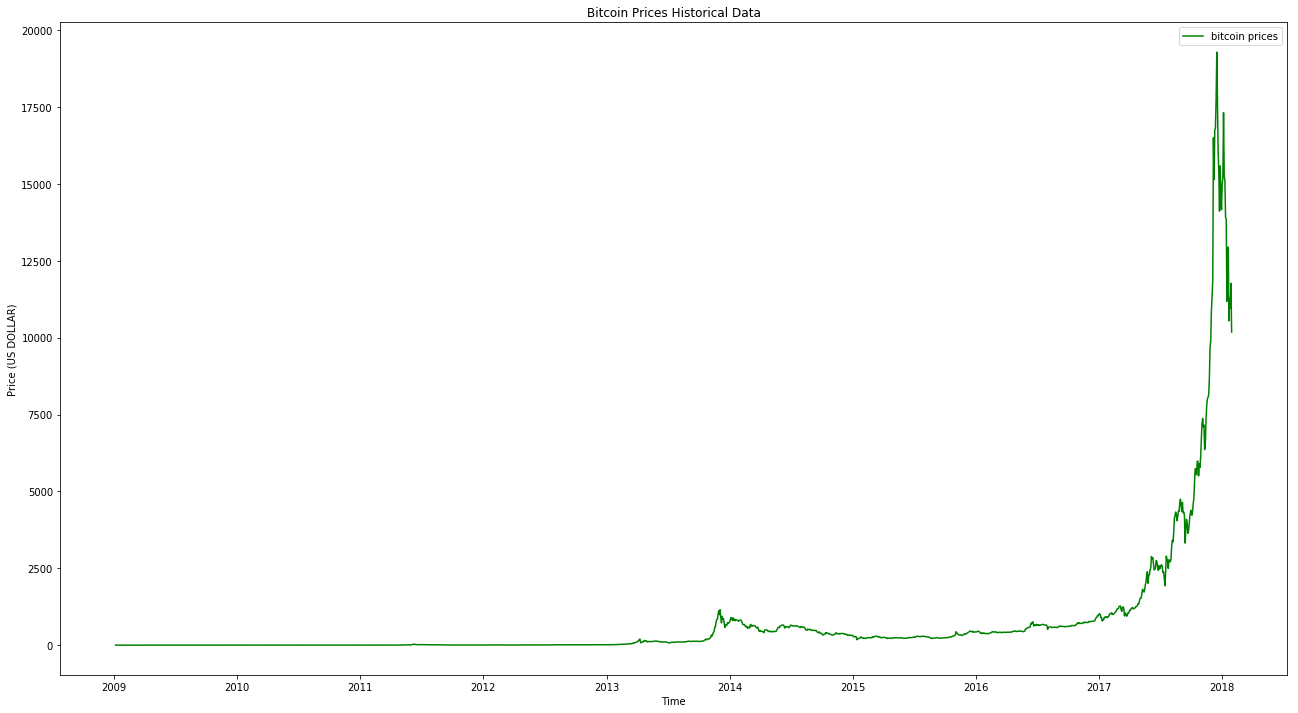

In [40]:
import matplotlib.pyplot as plt
import datetime as dt

# creating timestamps for the x axis
df_dates = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S').date() for d in df.DATE]

plt.figure(figsize=(22,12))
plt.plot(df_dates, df.PRICE, color='green', label='bitcoin prices')
plt.title('Bitcoin Prices Historical Data')
plt.ylabel('Price (US DOLLAR)')
plt.xlabel('Time')
plt.legend()
plt.show()

## Model: LSTM

### Why?

Since our data is a time series, recurrent neural networks are a natural fit.
This is due to the chain-like nature of RNNs.

RNNs loop their output back to themselves, which enables them to persist state for a while and learn based on previous learnings.

Something that is great for time series data.

![RNN loop](img/rnn.png)

If we unroll the loop, the chain-like nature becomes more obvious.

![RNN unrolled](img/rnn-unrolled.png)

This chain-like nature shows a strong relationship to sequences and lists. RNNs are a NN architecture that naturally fits sequences and lists.

### What are LSTMs?

LSTMs are a special kind of RNN (that's why I was talking about RNNs so much previously).

They were introduced by [Hochreiter & Schmidhuber in 1997](http://www.bioinf.jku.at/publications/older/2604.pdf).

LSTMs are specifically designed to tackle a problem called "Long Term Dependency Problem".

#### Long Term Dependency Problem

In theory, RNNs should be capable to predict, based on recent information. However, they don't seem to be able to learn once the gap between the relevant context and the point where it is needed grows too large.

This problem has been explored in depth by [Hochreiter in 1991](http://people.idsia.ch/~juergen/SeppHochreiter1991ThesisAdvisorSchmidhuber.pdf).

LSTMs do not have this problem, they are capable of learning long term dependencies.

The main difference is that, while other RNNs just have a single layer, LSTMs have four layers, that interact with each other in a very specific way.

Single layer of other RNNs:
![single layer rnn](img/rnn-single-layer.png)

LSTMs with four layers:
![four layer lstm](img/lstm-four-layers.png)

## Training the LSTM

### Preparing the training and test set

#### batch size

The batch size is the number of data points shown to the neural network per iteration. The weights are updated after each batch.

#### time steps

Time steps are the number of steps used to predict n steps. So, for example, use 20 steps to predict 20 steps.

This is the range the LSTM is aware of for its context.

#### epochs

Epochs are the number times the neural network sees each data point. So, the number of times it goes through the whole training set.

#### training set length

The length of the training set must be dividable without a remainder by the batch size.

#### test set length

20% of the data set is a usable percentage in most cases. We go with that and adjust along the way if necessary.

In [41]:
BATCH_SIZE = 64
EPOCHS = 220
TIME_STEPS = 30

TEST_SIZE = 0.2

In [42]:
def calc_training_set_length(length, batch_size, test_percent):
    length *= 1 - test_percent # reserving part of the data set for testing later on
    return(int(length - (length % batch_size)))

In [43]:
def calc_test_length(length, batch_size, time_steps, padded_training_size):
    length -= time_steps * 2
    length -= padded_training_size
    return(int(length - (length % batch_size)))

In [44]:
training_set_length = calc_training_set_length(len(df), BATCH_SIZE, TEST_SIZE)

we need to add a bit of padding to the end of the training set, otherwise it would go out of scope when it steps through the last bit of the training set.

![training set padding](img/padding.png)

In [45]:
train_with_padding = training_set_length + TIME_STEPS * 2
df_train = df[0:train_with_padding]
training_set = df_train.iloc[:,1:].values

#### Feature scaling

Feature scaling is quite important for a lot of ANNs. If we do not scale our features they will easily saturate our first hidden layer from the beginning. When an error gets backpropagated to a saturated neuron it gets blocked from propagating further. Which means that the weights will not really be trained, or much slower, causing the ANN to converge much much slower.

In [46]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
scaled_training_set = sc.fit_transform(training_set)

We are now finally building our training set. First we build an array of arrays with the length we calculated before.
The "inside" arrays are of length TIME_STEPS. The only difference between X and y is that when looking at the same index on both, X has the TIME_STEPS sized previous datapoints, while y has the TIME_STEPS sized following datapoints.

One point to note: We will step through the data one data point at a time, so our TIMESTEPS * 2 window of datapoints "moves" one by one.

![training set window](img/training-set-window.png)

In [47]:
X_train = []
y_train = []

for i in range(TIME_STEPS, training_set_length + TIME_STEPS):
    X_train.append(scaled_training_set[i - TIME_STEPS:i, 0])
    y_train.append(scaled_training_set[i:i + TIME_STEPS, 0])

After we build up our data, we need to reshape it into something that can be used to train our LSTM.

We just need to reshape it from our array of arrays into [training_set_length, TIME_STEPS, vector]

In [48]:
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(1280, 30, 1)
(1280, 30, 1)


### Train

In [49]:
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model

In [50]:
# We are using MAE as loss function
inputs_1_mae = Input(batch_shape=(BATCH_SIZE, TIME_STEPS, 1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_5 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_6 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_3 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


### Parameters

PARAMETERS = 4 × LSTM outputs size × (weights LSTM inputs size + weights LSTM outputs size + 1 bias variable)

In [51]:
for i in range(EPOCHS):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size=BATCH_SIZE)
    regressor_mae.reset_states()

Epoch: 0
Epoch 1/1
1280/1280 [==============================] - 2s 1ms/step - loss: 0.1192
Epoch: 1
Epoch 1/1
1280/1280 [==============================] - 0s 368us/step - loss: 0.1229
Epoch: 2
Epoch 1/1
1280/1280 [==============================] - 0s 368us/step - loss: 0.0988
Epoch: 3
Epoch 1/1
1280/1280 [==============================] - 0s 366us/step - loss: 0.0622
Epoch: 4
Epoch 1/1
1280/1280 [==============================] - 0s 363us/step - loss: 0.0557
Epoch: 5
Epoch 1/1
1280/1280 [==============================] - 0s 363us/step - loss: 0.0451
Epoch: 6
Epoch 1/1
1280/1280 [==============================] - 0s 366us/step - loss: 0.0496
Epoch: 7
Epoch 1/1
1280/1280 [==============================] - 0s 366us/step - loss: 0.0469
Epoch: 8
Epoch 1/1
1280/1280 [==============================] - 0s 370us/step - loss: 0.0496
Epoch: 9
Epoch 1/1
1280/1280 [==============================] - 0s 369us/step - loss: 0.0463
Epoch: 10
Epoch 1/1
1280/1280 [==============================] - 0s 364u

1280/1280 [==============================] - 0s 362us/step - loss: 0.0431
Epoch: 88
Epoch 1/1
1280/1280 [==============================] - 0s 368us/step - loss: 0.0420
Epoch: 89
Epoch 1/1
1280/1280 [==============================] - 0s 362us/step - loss: 0.0437
Epoch: 90
Epoch 1/1
1280/1280 [==============================] - 0s 361us/step - loss: 0.0397
Epoch: 91
Epoch 1/1
1280/1280 [==============================] - 0s 359us/step - loss: 0.0405
Epoch: 92
Epoch 1/1
1280/1280 [==============================] - 0s 365us/step - loss: 0.0395
Epoch: 93
Epoch 1/1
1280/1280 [==============================] - 0s 359us/step - loss: 0.0437
Epoch: 94
Epoch 1/1
1280/1280 [==============================] - 0s 360us/step - loss: 0.0394
Epoch: 95
Epoch 1/1
1280/1280 [==============================] - 0s 359us/step - loss: 0.0398
Epoch: 96
Epoch 1/1
1280/1280 [==============================] - 0s 364us/step - loss: 0.0410
Epoch: 97
Epoch 1/1
1280/1280 [==============================] - 0s 363us/step -

1280/1280 [==============================] - 0s 356us/step - loss: 0.0406
Epoch: 174
Epoch 1/1
1280/1280 [==============================] - 0s 362us/step - loss: 0.0409
Epoch: 175
Epoch 1/1
1280/1280 [==============================] - 0s 361us/step - loss: 0.0409
Epoch: 176
Epoch 1/1
1280/1280 [==============================] - 0s 361us/step - loss: 0.0444
Epoch: 177
Epoch 1/1
1280/1280 [==============================] - 0s 360us/step - loss: 0.0425
Epoch: 178
Epoch 1/1
1280/1280 [==============================] - 0s 361us/step - loss: 0.0405
Epoch: 179
Epoch 1/1
1280/1280 [==============================] - 0s 357us/step - loss: 0.0420
Epoch: 180
Epoch 1/1
1280/1280 [==============================] - 0s 363us/step - loss: 0.0399
Epoch: 181
Epoch 1/1
1280/1280 [==============================] - 0s 359us/step - loss: 0.0443
Epoch: 182
Epoch 1/1
1280/1280 [==============================] - 0s 360us/step - loss: 0.0417
Epoch: 183
Epoch 1/1
1280/1280 [==============================] - 0s 36

### Test

creating the test set is quite similar to creating the training set. We are also going to scale and shape the set.

We are getting the largest possible data set above the padded training set that is dividable by batch size without modulo.

In [52]:
testset_length = calc_test_length(len(df), BATCH_SIZE, TIME_STEPS, train_with_padding)
test_with_padding = testset_length + TIME_STEPS * 2 + train_with_padding

df_test = df[train_with_padding:test_with_padding] 
test_set = df_test.iloc[:,1:].values

Yes, this is actually repetitive and we will very likely build a pipeline for our scaling and shaping.

In [53]:
scaled_test_values = sc.fit_transform(test_set)

X_test = []
for i in range(TIME_STEPS, testset_length + TIME_STEPS):
    X_test.append(scaled_test_values[i - TIME_STEPS:i, 0])
X_test = np.array(X_test)

# shaping the test set, same as with the training set
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#### Predicions

In [54]:
predicted_mae = regressor_mae.predict(X_test, batch_size = BATCH_SIZE)
regressor_mae.reset_states()

print(predicted_mae.shape)

# reshaping - this should probably look familiar by now
predicted_mae = np.reshape(predicted_mae, (predicted_mae.shape[0], predicted_mae.shape[1]))

print(predicted_mae.shape)

# inverse transform
predicted_mae = sc.inverse_transform(predicted_mae)

y_test = []
for j in range(0, testset_length - TIME_STEPS):
    y_test = np.append(y_test, predicted_mae[j, TIME_STEPS - 1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(256, 30, 1)
(256, 30)
(226, 1)


#### Visualize the results

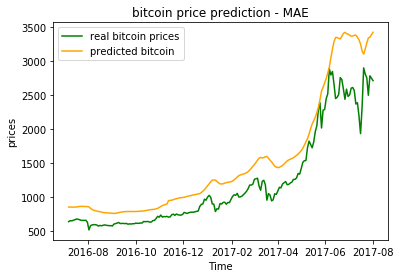

In [55]:
# Visualising the results
dates = df[train_with_padding:test_with_padding].DATE.values
dates = dates[TIME_STEPS:len(y_test)]
dates = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S').date() for d in dates]

plt.plot(dates, test_set[TIME_STEPS:len(y_test)], color = 'green', label = 'real bitcoin prices')
plt.plot(dates, y_test[0:len(y_test) - TIME_STEPS], color = 'orange', label = 'predicted bitcoin')
plt.title('bitcoin price prediction - MAE')
plt.xlabel('Time')
plt.ylabel('prices')
plt.legend()
plt.show()

### Measure

In [56]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[TIME_STEPS:len(y_test)], y_test[0:len(y_test) - TIME_STEPS]))
print(rmse)

385.8419121779347


In [57]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[TIME_STEPS:len(y_test)], y_test[0:len(y_test) - TIME_STEPS])
print(mae)

318.57452680251333


the RMSE is probably more interesting, since it punishes larger errors more. Which, for price predictions sound about right.

## What's next?

Our current model is not all that great at predicting. There are plenty of ways to optimize this, getting a better data set and using another loss function like MSE would probably be the first on the list.

Once the model predictions are satisfying it should be moved from the notebook into proper code. Something that is flexible enough to predict upcoming prices on current prices and that could be easily retrained with updated data points (online learning).